#Airbus ship detection

After preprocessing original data ,  we are going to upload from Google Drive a compressed folder which includes 4414 Images (in these images there are 0 ships to 15 ships) and a csv file which includes images related annotations. The number of images of each class (number of ships inside each image) has been balanced as much as possible.

As it was said in preprocessing file, Unet segmentation neural network has been choosen for this challenge. However some months ago, a modification of Unet model called  MultiResUnet began to be used for this kind of problems. Thus both models will be tested.

The tests will be performed in the following way:

- Unet Model
- Classification Model+Unet Model
- Classification Model+MultiResUnet Model if classification improves segmentation if not, only MultiResUnet

Once, we have checked which the best model is, a compressed folder containing new images will be uploaded and an encoded csv file will be generated with best model using run length encoding.

Even with a reduced number of images, we have got RAM "Out of memory errors" . To fix that problem, original images shape has been reduced from 768pixels x 768pixels to 256pixels x 256pixels for all the models.

In [0]:
# librairies installation for importing files from google drive and if necessary for unzipping them
!pip install -U -q PyDrive
!apt-get install unrar

In [0]:
#importing basic librairies
import os,sys,random
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from skimage.io import imread,imsave
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import statistics
from skimage.morphology import label

In [0]:
#importing keras librairies
import keras
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers import concatenate,Conv2D,Input,MaxPooling2D,UpSampling2D,Activation                   
from keras.models import Model
from keras.losses import binary_crossentropy
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [0]:
#importing librairies for  interaction between Google Collaboratory and  Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#images uploading and unzipping
!rm -rf airbus_ship_images_4414
!mkdir airbus_ship_images_4414
downloaded = drive.CreateFile({'id':'1evGEt5R8EDNnc3ahdGym2DcJOzlJ3sc2'})
downloaded.GetContentFile('airbus_ship_images_4414.rar')
!unrar e -y *.rar /content/airbus_ship_images_4414/ -idq
!rm *.rar

In [0]:
#annotations file uploading
downloaded = drive.CreateFile({'id':'12SSXo4TWIaWJ7K_lCRvmmQj1fRMSy-rS'})
downloaded.GetContentFile('ships_sample.csv')

In [0]:
#reading annotations(ImageId and EncodedPixels are relevant features in Segmentation)
masks = pd.read_csv('ships_sample.csv')
masks.head()

,ImageId,EncodedPixels,ship
0,36a387570.jpg,421238 2 422004 4 422770 7 423536 9 424302 12 ...,9
1,f9cfb3893.jpg,233860 1 234626 3 235393 5 236159 7 236926 9 2...,5
2,e2f8755ab.jpg,163271 1 164038 3 164805 5 165572 7 166339 9 1...,3
3,75443d8ee.jpg,530832 3 531600 7 532367 13 533135 17 533903 2...,6
4,b4fbf682c.jpg,493983 2 494751 4 495518 7 496286 9 497053 12 ...,6


In [0]:
#decoding function modified from Kaggle users original function
def rle_decode(mask_rle, shape=(768, 768)):
  '''
    CSV file 'ships_sample.csv'
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 -> mask, 0 -> background
  '''  
  if type(mask_rle)==float:
    #if value is not a string there is no ship
    return np.zeros(shape)
  else:
    #string "EncodedPixels" is divided in couples(position,length)
    #from position to position+length mask values are 1
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
      img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [0]:
#generation of mask array for each image after decoding run length code(1->ship in that pixel, 0->no ship in that pixel)
def mask_gen(df,img_name):
  
  masks_list = df.loc[df['ImageId'] == img_name, 'EncodedPixels'].tolist()  
    
  mask_array = np.zeros((768, 768))
  
  for mask in masks_list:
                
    mask_array += rle_decode(mask)
        
  return mask_array

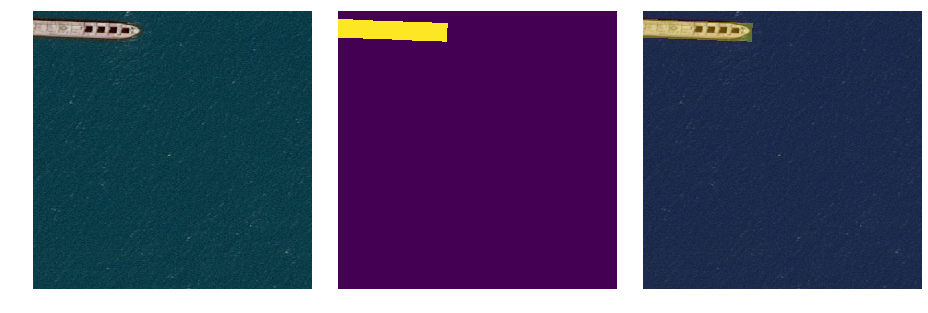

In [0]:
#image test to check decoding function
ImageId = 'c46f21c90.jpg'

img = imread('airbus_ship_images_4414/' + ImageId)
  
all_masks=mask_gen(masks,ImageId)

fig, axarr = plt.subplots(1, 3, figsize=(13, 10))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img)
axarr[2].imshow(all_masks, alpha=0.3)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

In [0]:
# data splitting -> training 80% and validation 20% 
# class proportion(number of ships in each image) is maintained with stratify parameter in training and validation sets
X=masks
y=masks['ship']
img_train, img_val, n_ships_train, n_ships_val = train_test_split(X, y, test_size = 0.2,stratify=y,random_state=50)

In [0]:
#checking that train and validation sets are balanced concerning the number of ships in images
for i in range(0,len(n_ships_train.value_counts().sort_index())):
  print("Class {0:>2} ({1:>2} ship(s))       % in train set {2:.2f}      % in validation set {3:.2f}".format(i,i,n_ships_train.value_counts().sort_index()[i]/len(img_train)*100,n_ships_val.value_counts().sort_index()[i]/len(img_val)*100))

Class  0 ( 0 ship(s))       % in train set 9.06      % in validation set 9.06
Class  1 ( 1 ship(s))       % in train set 9.06      % in validation set 9.06
Class  2 ( 2 ship(s))       % in train set 9.06      % in validation set 9.06
Class  3 ( 3 ship(s))       % in train set 9.06      % in validation set 9.06
Class  4 ( 4 ship(s))       % in train set 9.06      % in validation set 9.06
Class  5 ( 5 ship(s))       % in train set 9.06      % in validation set 9.06
Class  6 ( 6 ship(s))       % in train set 9.06      % in validation set 9.06
Class  7 ( 7 ship(s))       % in train set 9.06      % in validation set 9.06
Class  8 ( 8 ship(s))       % in train set 7.19      % in validation set 7.25
Class  9 ( 9 ship(s))       % in train set 5.49      % in validation set 5.55
Class 10 (10 ship(s))       % in train set 3.82      % in validation set 3.74
Class 11 (11 ship(s))       % in train set 3.26      % in validation set 3.28
Class 12 (12 ship(s))       % in train set 2.80      % in valida

In [0]:
# generation of batches of images and masks
# df-> dataframe where features are read
# new size is the size of the input images used to train unet or multiResUnet networks
# batch size is the number of training images in one forward/backward pass through the neural network.
# in this generator images are always in the same position in whole image list
def deterministic_image_batch_generator(df,new_size,batch_size=256):
  
  batch_img, batch_mask = [], []
  
  list_batches=list(df['ImageId'])
  
  while True:
    
    batch_img= []
    
    for img_name in list_batches:
      #image resizing
      img_path = os.path.join('airbus_ship_images_4414/',img_name)
      img = Image.open(img_path)
      img_resized = img.resize((new_size,new_size),Image.ANTIALIAS)
      
      np_image = np.array(img_resized)
      
      mask_array=mask_gen(df,img_name)
      
      mask= Image.fromarray(mask_array)
      mask_resized = mask.resize((new_size,new_size),Image.ANTIALIAS)
      
      np_mask = np.array(mask_resized)
      #resizing mask array to meet keras input array requirement
      np_mask = np_mask[:,:,np.newaxis]
      #batch list of images
      batch_img.append(np_image)
      #batch list of masks
      batch_mask.append(np_mask)
      
      if len(batch_img)>=batch_size:
        # transformation list->array(images and masks) and normalisation of images
        yield np.stack(batch_img, axis=0)/255., np.stack(batch_mask, axis=0)
        batch_img, batch_mask=[], []
    # total number of images is not a multiple of batch_size-> residual batch_size lower than all other batches size  
    if len(batch_img) !=0:
        #transformation list->array(images and masks) and normalisation of images
        yield np.stack(batch_img, axis=0)/255., np.stack(batch_mask, axis=0)
        batch_img, batch_mask=[], []         

In [0]:
# generation of batches of images and masks
# df-> dataframe where features are read
# new size is the size of the input images used to train unet or multiResUnet networks
# batch size is the number of training images in one forward/backward pass through the neural network.
# in this generator images are randomly placed in the whole image list for every batch
def random_image_batch_generator(df,new_size,batch_size=64):
  
  batch_img, batch_mask = [], []
    
  list_batches=list(df['ImageId'])
  
  while True:
    
    np.random.shuffle(list_batches)
    #shuffle is used in case all training images cannot be trained due to RAM out of memory error
    #using random batches at the end of each epoch a higher number of images are used to train neural network with a better result 
    
    for img_name in list_batches:
      #image resizing
      img_path = os.path.join('airbus_ship_images_4414/',img_name)
      img = Image.open(img_path)
      img_resized = img.resize((new_size,new_size),Image.ANTIALIAS)
      
      np_image = np.array(img_resized)
      
      mask_array=mask_gen(df,img_name)
      
      mask= Image.fromarray(mask_array)
      mask_resized = mask.resize((new_size,new_size),Image.ANTIALIAS)
      
      np_mask = np.array(mask_resized)
       #resizing mask array to meet keras input array requirement
      np_mask = np_mask[:,:,np.newaxis]
      
      batch_img.append(np_image)
      
      batch_mask.append(np_mask)
      
      if len(batch_img)>=batch_size:
        # transformation list->array and normalisation of images
        yield np.stack(batch_img, axis=0)/255., np.stack(batch_mask, axis=0)
        batch_img, batch_mask=[], []
      
    if len(batch_img) !=0:
        #transformation list->array and normalisation of images
        yield np.stack(batch_img, axis=0)/255., np.stack(batch_mask, axis=0)
        batch_img, batch_mask=[], []  

In [0]:
#batches generation for images and masks (testing purpose)
train_batch=random_image_batch_generator(img_train,256)
train_batch_image,train_batch_mask=next(train_batch)
print(train_batch_image.shape,train_batch_mask.shape)

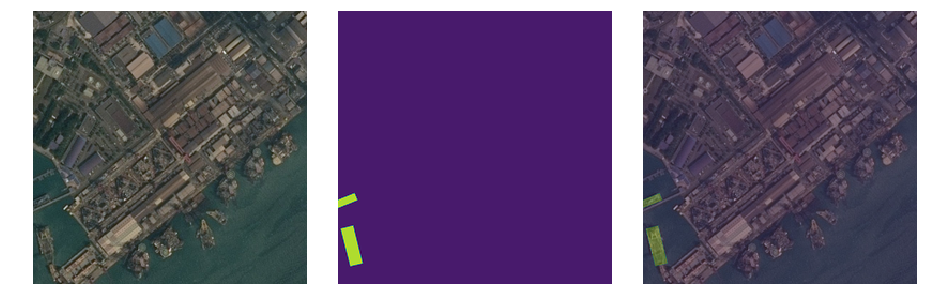

In [0]:
#example of plotting an image and a mask among images and masks batches
img=train_batch_image[5]
all_masks=np.squeeze(train_batch_mask[5], axis=(2,))
fig, axarr = plt.subplots(1, 3, figsize=(13, 30))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img)
axarr[2].imshow(all_masks, alpha=0.3)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

##Unet Model

![Unet Model](https://docs.google.com/uc?id=1X7SV1U-e0Z0I_lkvCyVnGrzIXMq6qA-w)

Unet is a encoding-decoding neural network. In previous figure, encoding is on the left side and decoding is on the right side. 

Encoding is use to extract image features using filters(blue blocks). In encoding process figure size is reduced by 2 (height and width) by maxPooling function which keeps the most significative pixel for every 2pixels x 2 pixels filter moving all over the image.

Decoding is use to reconstruct image context by increasing size by 2(height and width) using Transpose Convolution (or UpSample) function and recovering features from encoding part using skip connection and concatenation.

In [0]:
# sequence of 2 (convolutional function + Batch Normalisation)
def encode_block(inp,n_filters,n_rows,n_cols,strides=(1, 1),padding='same',activation='relu',bn=True):
  #convolutional function with n_filters, kernel_filter-> n_rows x n_cols
  output = Conv2D(filters=n_filters,kernel_size=(n_rows,n_cols),strides=strides,padding=padding,activation=activation)(inp)
    
  if bn:#after convolution a weights normalisation can be optionaly performed
    
    output = BatchNormalization()(output) #normalisation of model weights to avoid overfitting
  #convolutional function with n_filters n_rows x n_cols      
  output = Conv2D(filters=n_filters,kernel_size=(n_rows,n_cols),strides=strides,padding=padding,activation=activation)(output)
    
  if bn:#after convolution a weights normalisation can be optionaly performed
    
    output = BatchNormalization()(output) #normalisation of model weights to avoid overfitting
    
  return output

#Upsampling + concatenation+convolutional functions
def decode_block(inp1,inp2,n_filters,n_rows,n_cols,strides=(1, 1),padding='same',activation='relu',bn=True):
  
  up=UpSampling2D()(inp1)#increasing image size by 2, filling the unknown values by interpolation
  
  conc=concatenate([inp2, up],axis=3)#direct concatenation of encoding outputs and UpSampling output
  
  #sequence of 2 (convolutional function + Batch Normalisation)
  output= encode_block(conc,n_filters,n_rows,n_cols,strides=strides,padding=padding,activation=activation,bn=bn)
  
  return output


def Unet(height,width,n_channels):
    
  inputs = Input(shape=(height, width, n_channels))
  #height->image height
  #width ->image width
  #n_channels->image number of channels(3 for a coloured image and 1 for a greyscale image)
  # input shape(height,width,n_channels)
  encode1=encode_block(inputs,16,3,3,padding='same',activation='relu')#encoding block with non linear 'relu' function
  mp1=MaxPooling2D(pool_size=(2, 2))(encode1)# reducing image size by 2, keeping the most significant pixel after filter 2x2
  # input shape(height/2,width/2,16) 
  encode2=encode_block(mp1,24,3,3,padding='same',activation='relu')#encoding block with non linear 'relu' function
  mp2=MaxPooling2D(pool_size=(2, 2))(encode2)# reducing image size by 2, keeping the most significant pixel after filter 2x2
  # input shape(height/4,width/4,24)   
  encode3=encode_block(mp2,32,3,3,padding='same',activation='relu')#encoding block with non linear 'relu' function
  mp3=MaxPooling2D(pool_size=(2, 2))(encode3)# reducing image size by 2, keeping the most significant pixel after filter 2x2
  # input shape(height/8,width/8,32)  
  encode4=encode_block(mp3,48,3,3,padding='same',activation='relu')#encoding block with non linear 'relu' function
  mp4=MaxPooling2D(pool_size=(2, 2))(encode4)# reducing image size by 2, keeping the most significant pixel after filter 2x2
  #input shape(height/16,width/16,48)  
  encode5=encode_block(mp4,64,3,3,padding='same',activation='relu')#encoding block with non linear 'relu' function
  mp5=MaxPooling2D(pool_size=(2, 2))(encode5)# reducing image size by 2, keeping the most significant pixel after filter 2x2

  #input shape(height/32,width/32,64)  
  encode6=encode_block(mp5,96,3,3,padding='same',activation='relu')#encoding block with non linear 'relu' function
  mp6=MaxPooling2D(pool_size=(2, 2))(encode6)# reducing image size by 2, keeping the most significant pixel
  #input shape(height/64,width/64,96)   
  encode7=encode_block(mp6,128,3,3,padding='same',activation='relu')#encoding block with non linear 'relu' function
  #input shape(height/64,width/64,128)  
  decode1=decode_block(encode7,encode6,96,3,3,padding='same',activation='relu')#decoding block with non linear 'relu' function
  #input shape(height/32,width/32,96)  
  decode2=decode_block(decode1,encode5,64,3,3,padding='same',activation='relu')#decoding block with non linear 'relu' function
  #input shape(height/16,width/16,64)  
  decode3=decode_block(decode2,encode4,48,3,3,padding='same',activation='relu')#decoding block with non linear 'relu' function
  #input shape(height/8,width/8,48)  
  decode4=decode_block(decode3,encode3,32,3,3,padding='same',activation='relu')#decoding block with non linear 'relu' function
  #input shape(height/4,width/4,32)
  decode5=decode_block(decode4,encode2,24,3,3,padding='same',activation='relu')#decoding block with non linear 'relu' function
  #input shape(height/2,width/2,24)
  decode6=decode_block(decode5,encode1,16,3,3,padding='same',activation='relu')#decoding block with non linear 'relu' function
  #input shape(height,width,16)       
  outputs = Conv2D(filters=1,kernel_size=(1,1),activation='sigmoid') (decode6)#convolutional function followed by a 'sigmoid' function
   
  model = Model(inputs, outputs)
    
  return model

In [0]:
#unet model creation with 256x256 resized coloured images
unet=Unet(256,256,3)

In [0]:
unet.summary()

In [0]:
#dice_coef measures the overlap of 2 masks (in a mask, image pixels value is 1 and background pixels value is 0)
#dice_coef ->measures the sum of all the "1" values common to both masks divided by the number of "1" value pixels 
#of first mask + the number of "1" value pixels of second mask)
#in this particular case first mask is ground truth mask and second mask is prediction mask
def dice_coef(y_true, y_pred):#metrics
    smooth = 1.#coefficient to avoid division by 0 when y_true=0 and y_pred=0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
  
def dice_loss(in_true, in_pred):
    return 1-dice_coef(in_true, in_pred)
  
def dice_bce_loss(in_true, in_pred):#loss function
    return binary_crossentropy(in_true, in_pred) +1 - dice_coef(in_true, in_pred)

In [0]:
#model compilation with a (cross_entropy + dice_loss) loss function and dice_coef metrics
unet.compile(optimizer=Adam(1e-3, decay=2e-6),loss=dice_bce_loss,metrics=[dice_coef])

In [0]:
#as a small amount of images is used to train neural network, at each batch,several operations are randomly performed on images
#these operations are rotation,shifting,zooming and flipping and they augment artificially the number of different images
data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

Img_datagen = ImageDataGenerator(**data_gen_args)
Mask_datagen = ImageDataGenerator(**data_gen_args)

def augmentation_generator(img_batch_gen,img_datagen,mask_datagen):
  
  for in_img, in_mask in img_batch_gen:
    seed = np.random.choice(range(1000))
    # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
    #images are denormalize to apply augmentation operations
    aug_img = img_datagen.flow(255*in_img,batch_size = in_img.shape[0],seed=seed,shuffle=True)
    aug_mask = mask_datagen.flow(in_mask,batch_size = in_mask.shape[0],seed=seed,shuffle=True)
    #images are normalized again to be applied to neural network
    yield next(aug_img)/255.0, next(aug_mask)

In [0]:
#parameters of model fit function
#train generator has the following shape (48,256,256,3) 48 coloured images 256pixels x 256pixels 
train_generator=augmentation_generator(deterministic_image_batch_generator(img_train, 256,batch_size=48),Img_datagen,Mask_datagen)
val_generator=next(deterministic_image_batch_generator(img_val,256,batch_size=len(img_val)))
steps_train=len(img_train)//48

In [0]:
#callback functions: 
#saving best weights, save metrics and losses in file batch_unet_weights.best.hdf5
#learning rate is reduced at 90% if result dice_coef is not improved in 3 epochs
#training is stopped if dice_coef result is not improved after 25 epochs
weight_path="{}_weights.best.hdf5".format('batch_unet')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.9, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=25) # probably needs to be more patient, but kaggle time is limited

callbacks_segmentation = [checkpoint, early, reduceLROnPlat]

In [0]:
#training the model
loss_unet=unet.fit_generator(train_generator, validation_data=val_generator, steps_per_epoch=steps_train, epochs=180,workers=1,callbacks=callbacks_segmentation)

Instructions for updating:
Use tf.cast instead.
Epoch 1/180
73/73 [==============================] - 200s 3s/step - loss: 1.5876 - dice_coef: 0.0196 - val_loss: 2.2460 - val_dice_coef: 0.0208

Epoch 00001: val_dice_coef improved from -inf to 0.02082, saving model to batch_unet_weights.best.hdf5
Epoch 2/180
73/73 [==============================] - 183s 3s/step - loss: 1.3691 - dice_coef: 0.0282 - val_loss: 3.1035 - val_dice_coef: 0.0193

Epoch 00002: val_dice_coef did not improve from 0.02082
Epoch 3/180
73/73 [==============================] - 190s 3s/step - loss: 1.1704 - dice_coef: 0.0483 - val_loss: 3.1914 - val_dice_coef: 0.0299

Epoch 00003: val_dice_coef improved from 0.02082 to 0.02989, saving model to batch_unet_weights.best.hdf5
Epoch 4/180
73/73 [==============================] - 189s 3s/step - loss: 1.0225 - dice_coef: 0.0940 - val_loss: 1.0024 - val_dice_coef: 0.1386

Epoch 00004: val_dice_coef improved from 0.02989 to 0.13864, saving model to batch_unet_weights.best.hdf5
E

In [0]:
#downloading best weight values file to PC
files.download('batch_unet_weights.best.hdf5')

In [0]:
#plot of 2 figures: loss(training and validation) vs nºepochs and dice_coef(training and validation) vs nºepochs
def show_loss(loss):
    
    #plt.style.use('dark_background')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    _ = ax1.plot(np.arange(0, len(loss.history['val_loss'])), loss.history["val_loss"], label="val_loss")
    _ = ax1.plot(np.arange(0, len(loss.history['loss'])), loss.history["loss"], label="loss")
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')
    ax1.set_xlabel('num_epochs')
    
    _ = ax2.plot(np.arange(0, len(loss.history['val_dice_coef'])), loss.history["val_dice_coef"], label="val_dice_coef")
    _ = ax2.plot(np.arange(0, len(loss.history['dice_coef'])), loss.history["dice_coef"], label="dice_coef")
    ax2.legend(['Validation', 'Training'])
    ax2.set_title('DICE')
    ax1.grid()
    ax2.grid()
    ax2.set_xlabel('num_epochs')
    plt.show()

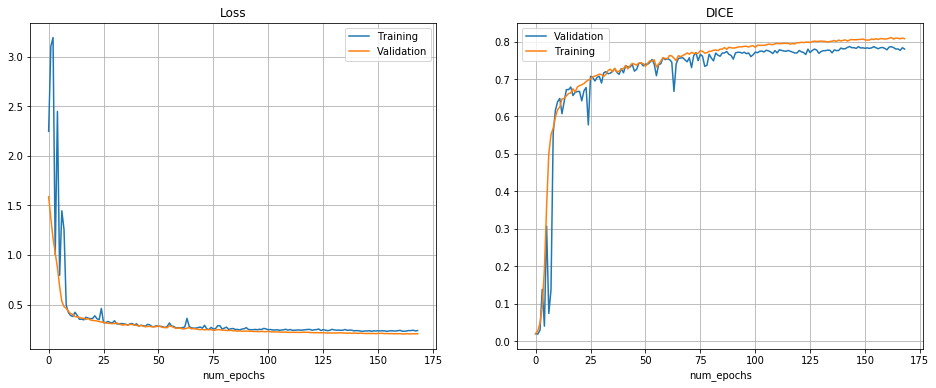

In [0]:
#plotting model losse and dice_coeff
show_loss(loss_unet)

In [0]:
unet.load_weights('batch_unet_weights.best.hdf5')

In [0]:
#generation of validation batches for evaluating model
val_batch_image,val_batch_mask=next(deterministic_image_batch_generator(img_val,256,batch_size=len(img_val)))

In [0]:
#segmentation result without preclassification
print(unet.evaluate(val_batch_image,val_batch_mask))

883/883 [==============================] - 5s 5ms/step
[0.23023231791612922, 0.7873708617916734]


##Classification Model + Unet Model

In [0]:
#convolutional neural network
def Classifier(height,width,n_channels):
    #image height
    #image width 
    #image channels: 1 for grey images and 3 for color images
    inputs = (height, width, n_channels)
    
    classifier=Sequential()
    #input convolutional layer 32 filters 3x3
    classifier.add(Conv2D(32,kernel_size=(3,3),input_shape=inputs))
    classifier.add(Activation('relu'))
    classifier.add(BatchNormalization())#normalisation of weights to avoid overfitting
    classifier.add(MaxPooling2D(2,2))
    #hidden convolutional layer nº1 48 filters 3x3
    classifier.add(Conv2D(48,kernel_size=(3,3)))
    classifier.add(Activation('relu'))
    classifier.add(BatchNormalization())#normalisation of weights to avoid overfitting
    classifier.add(MaxPooling2D(2,2))
    #hidden convolutional layer nº2 64 filters 3x3
    classifier.add(Conv2D(64,kernel_size=(3,3)))
    classifier.add(Activation('relu'))
    classifier.add(BatchNormalization())#normalisation of weights to avoid overfitting
    classifier.add(MaxPooling2D(2,2))
    #hidden convolutional layer nº3 96 filters 3x3
    classifier.add(Conv2D(96,kernel_size=(3,3)))
    classifier.add(Activation('relu'))
    classifier.add(BatchNormalization())#normalisation of weights to avoid overfitting
    classifier.add(MaxPooling2D(2,2))
    #hidden convolutional layer nº4 128 filters 3x3
    classifier.add(Conv2D(128,kernel_size=(3,3)))
    classifier.add(Activation('relu'))
    classifier.add(BatchNormalization())#normalisation of weights to avoid overfitting
    classifier.add(MaxPooling2D(2,2))
    #convolutional layers output is flattened into a vector
    classifier.add(Flatten())
    #hidden dense layer 128 neurons
    classifier.add(Dense(units=128))
    classifier.add(BatchNormalization())#normalisation of weights to avoid overfitting
    classifier.add(Dropout(0.3))#random deactivation of 30% of neurons to avoid overfitting
    #output dense layer 1 neuron
    classifier.add(Dense(units=1))
    classifier.add(BatchNormalization())#normalisation of weights to avoid overfitting
    classifier.add(Activation('sigmoid'))
    
    return classifier

In [0]:
#classifier model creation with 256x256 resized coloured images
classifier=Classifier(256,256,3)

In [0]:
#uploading of classifier best weights file
downloaded = drive.CreateFile({'id':'1mLMTAe46xjCc35u0epF2h24Ju_WaPMHA'})
downloaded.GetContentFile('classification_weights.best.hdf5')

In [0]:
#loading of classifier best weights
classifier.load_weights('classification_weights.best.hdf5')

In [0]:
#has_ship feature is added to original dataframe to know which images do not contain any images
masks['has_ship']=masks['ship'].apply(lambda x: 1 if x!=0 else x)

In [0]:
#splitting original data taking into account the number of ships('ship' feature)
# training ->80%  validation ->20%
X=masks
y=masks['ship']
z=masks['has_ship']
img_train, img_val, has_ship_train, has_ship_val = train_test_split(X, z, test_size = 0.2,stratify=y,random_state=50)

0


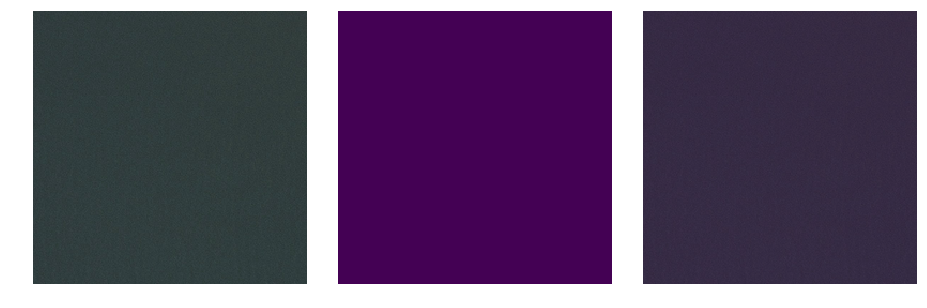

In [0]:
#once splitting has been done, an specific validation image with no ships will be chosen from validation batch, 
#in this case index=3
i=3
img=val_batch_image[i]
all_masks=np.squeeze(val_batch_mask[i], axis=(2,))
print(has_ship_val.iloc[i])
fig, axarr = plt.subplots(1, 3, figsize=(13, 30))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img)
axarr[2].imshow(all_masks, alpha=0.3)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

The procedure will be as follows:

We look for an image in validation batch with no ships and with a  segmentation prediction of 1 for  dice_coef metrics (see previous plot). This image (index=3 in validation batch) has an homogeneous color without objects of any kind, so it is foreseeable to get a very good value for prediction metrics.
Once this value has been chosing, we will use classification prediction to detect images with ships and without ships. Images predicted having no ships will be replaced by image with index=3. Then modified  images will be applied to unet segmentation. If the classification is good enough, we may expect an improvement of segmentation mainly in images where there are objects inside land (houses, cars,etc...)

In [0]:
#val_batch_image[3] is an image without ships 
ground=val_batch_image[3]

In [0]:
#prediction of classifier for all validation set specially for index=3-> pred_class_val[3]=0 and dice_coeff[3]=1
y_pred_class=classifier.predict(val_batch_image)
pred_class_val=np.where(y_pred_class>0.5,1,0)

In [0]:
#all the images which classification_prediction=0 will be replaced by ground image i.e. val_batch_image[3]
for i in range(len(pred_class_val)):
  if pred_class_val[i]<0.5:
    val_batch_image[i]=ground

In [0]:
#modified images are again evaluate and result is comparated to results without modification
print(unet.evaluate(val_batch_image,val_batch_mask))

883/883 [==============================] - 4s 4ms/step
[0.2462343710431426, 0.7740412718982416]


As the results are not improving(result with preclassification 0.7740 and result without preclassification 0.7874), classification + segmentation will be discarded. If we want to get good results by this method, we should improve previously classification results by training many more images. 

##MultiResUnet Model 

![texto alternativo](https://docs.google.com/uc?id=1OBrwjXvo1NgMwzPkIdFcAbZ_09gf05A8)

                                     MultiResUnet Structure figure

MultiResuNet is also an encoding-decoding neural network. In previous figure, encoding is on the left side and decoding is on the right side. (MultiResUNet : Rethinking the U-Net Architecturefor Multimodal Biomedical Image Segmentation Nabil Ibtehaz and M. Sohel Rahman)

In Unet network every encoding sub-block is made by 2 sequential convolutional functions with similar filter dimensions. In MultiResUnet network every encoding sub-block is made of 3 sequential convolutional functions with an increasing number of filters whose outputs are concatenated and added to the output of a convolutional function that has the same input of the 3 sequential convolutional functions

Decoding is similar to Unet network where TransposeConvolution (or UpSampling) is use to recover image size and context. The difference is that when recovering features of encoder the concatenation with encoded outputs is not made by a direct concatenation and in this case before the concatenation a ResPath function (mixture of convolutions and additions) is applied.

![texto alternativo](https://docs.google.com/uc?id=1HGw9rg8UgMdvVGzwhXJ6IEd28fICEUUl)

          MultiResBlock figure

![texto alternativo](https://docs.google.com/uc?id=1FnfI2aPCYNqolpzUrTJ-NtnthOqePF-u)

              ResPath figure

In [0]:
#convolutional function used in encoding block as well as in decoding block
def conv2d_bn(inp, n_filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu'):
  
  x = Conv2D(filters=n_filters,kernel_size=(num_row, num_col),strides=strides,padding=padding)(inp)
  
  if (activation != None):
    
    x = Activation(activation=activation)(x)# non linear function applied after convolution 
                                            # ('relu' function is usually used for input and hidden layers)  
  x = BatchNormalization()(x)# normalisation of network weights to avoid underfitting
 
  return x

# Succession of 3x3 convolutional filters whose outputs are concatenated and added to a residual connection (1x1 convolution)
def MultiResBlock(n_filters, inp):

  W = 1.5 * n_filters
  #residual connection ->convolution with a filters number of (int(W/6) + int(W/3) +int(W/2)) and (1x1) kernel_size 
  shortcut = conv2d_bn(inp, int(W/6) + int(W/3) +int(W/2), 1, 1, activation=None, padding='same')
  #convolution with a filters number of int(W/6) and (3x3) kernel_size 
  conv3x3 = conv2d_bn(inp, int(W/6), 3, 3,activation='relu', padding='same')
  #convolution with a filters number of int(W/3) and (3x3) kernel_size  
  conv5x5 = conv2d_bn(conv3x3, int(W/3), 3, 3,activation='relu', padding='same')
  #convolution with a filters number of int(W/2) and (3x3) kernel_size  
  conv7x7 = conv2d_bn(conv5x5, int(W/2), 3, 3,activation='relu', padding='same')
  #  3x3 convolution outputs are concatenated
  out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
  out = BatchNormalization(axis=3)(out)
  #residual connection is added to previous concatenation output  
  out = add([shortcut, out])
  out = Activation('relu')(out)
  out = BatchNormalization()(out)# weights normalisation

  return out

#Some convolution layers are included in the shorcut connections between encoder and decoder
#variable succession of 3x3 convolution filters with residual connections depending on the position in the network
def ResPath(filters, length, inp):
  #residual connection
  shortcut = conv2d_bn(inp, filters, 1, 1,activation=None, padding='same')

  out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

  out = add([shortcut,out])
  out = Activation('relu')(out)
  out = BatchNormalization()(out)

  for i in range(length-1):
    #residual connection
    shortcut = conv2d_bn(out, filters, 1, 1,activation=None, padding='same')
    #sucession of 3x3 convolutional filters
    out = conv2d_bn(out,filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization()(out)

  return out

def MultiResUnet(height,width,n_channels):
    
    inputs = Input(shape=(height, width, n_channels))
    #first encoding block input shape(heigth,width,n_channels)
    mresblock1 = MultiResBlock(8,inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1) #encoding block
    mresblock1 = ResPath(8,5,mresblock1)
    #second encoding block input shape(heigth/2,width/2,12)
    mresblock2 = MultiResBlock(16,pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2) #encoding block
    mresblock2 = ResPath(16,4,mresblock2)
    #third encoding block input shape(heigth/4,width/4,24)
    mresblock3 = MultiResBlock(32,pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3) #encoding block
    mresblock3 = ResPath(32,3,mresblock3)
    #fourth encoding block input shape(heigth/8,width/8,48)
    mresblock4 = MultiResBlock(64,pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4) #encoding block
    mresblock4 = ResPath(64,2,mresblock4)
    #fifth encoding block input shape(heigth/16,width/16,96)
    mresblock5 = MultiResBlock(128,pool4)
    pool5 = MaxPooling2D(pool_size=(2, 2))(mresblock5) #encoding block
    mresblock5 = ResPath(128,1,mresblock5)
    #input shape(heigth/32,width/32,192)
    mresblock6 = MultiResBlock(256,pool5)
    
    #first decoding block input shape(height/32,width/32,256)
    up1=UpSampling2D()(mresblock6)#increasing image size by 2, filling unknown values by interpolation
    conc1=concatenate([up1,mresblock5],axis=3)
    mresblock7 = MultiResBlock(128,conc1)
    #second decoding block input shape(height/16,width/192)
    up2=UpSampling2D()(mresblock7)#increasing image size by 2, filling unknown values by interpolation
    conc2=concatenate([up2,mresblock4],axis=3)
    mresblock8 = MultiResBlock(64,conc2)
    #third decoding block input shape(height/8,width/8,96)
    up3=UpSampling2D()(mresblock8)#increasing image size by 2, filling unknown values by interpolation
    conc3=concatenate([up3,mresblock3],axis=3)
    mresblock9 = MultiResBlock(32,conc3)
    #fourth decoding block input shape(height/4,width/4,48)
    up4=UpSampling2D()(mresblock9)#increasing image size by 2, filling unknown values by interpolation
    conc4=concatenate([up4,mresblock2],axis=3)
    mresblock10 = MultiResBlock(16,conc4)
    #fifth decoding block input shape(height/2,width/2,24)
    up5=UpSampling2D()(mresblock10)#increasing image size by 2, filling unknown values by interpolation
    conc5=concatenate([up5,mresblock1],axis=3)
    mresblock11 = MultiResBlock(8,conc5)
    
    #output layer->convolution function with a 'Sigmoid' non linear activation function, input shape(height,width,12)
    outputs = Conv2D(filters=1,kernel_size=(1,1),activation='sigmoid')(mresblock11)
    
    model = Model(inputs, outputs)
    
    return model

In [0]:
#multiResUnet model creation with 256x256 resized coloured images
multiResUnet=MultiResUnet(256,256,3)

In [0]:
multiResUnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 2)  56          input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 2)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 256, 256, 2)  8           activation_1[0][0]               
__________________________________________________________________________________________________
conv2d_3 (

In [0]:
#model compilation with a (cross_entropy + dice_loss) loss function and dice_coef metrics
multiResUnet.compile(optimizer=Adam(1e-3, decay=2e-6),loss=dice_bce_loss,metrics=[dice_coef])

In [0]:
#parameters of model fit function
#train generator has the following shape (48,256,256,3) 48 coloured images 256pixels x 256pixels
#validation generator has the following shape (img_val,256,256,3) img_val coloured images 256pixels x 256pixels
train_generator=augmentation_generator(random_image_batch_generator(img_train, 256,batch_size=48),Img_datagen,Mask_datagen)
val_generator=next(deterministic_image_batch_generator(img_val,256,batch_size=len(img_val)))
steps_train=len(img_train)//48

In [0]:
#callback functions: 
#saving best weights, save metrics and losses in file batch_multiresunet_weights.best.hdf5
#learning rate is reduced at 80% if result dice_coef is not improved in 3 epochs
#training is stopped if dice_coef result is not improved after 25 epochs
weight_path="{}_weights.best.hdf5".format('batch_multiresunet')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.8, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=25) # probably needs to be more patient, but kaggle time is limited

callbacks_segmentation = [checkpoint, early, reduceLROnPlat]

In [0]:
#training the model
loss_multiResUnet=multiResUnet.fit_generator(train_generator, validation_data=val_generator, steps_per_epoch=steps_train, epochs=190,workers=1,callbacks=callbacks_segmentation)

Instructions for updating:
Use tf.cast instead.
Epoch 1/210
73/73 [==============================] - 234s 3s/step - loss: 1.5891 - dice_coef: 0.0182 - val_loss: 1.4583 - val_dice_coef: 0.0298

Epoch 00001: val_dice_coef improved from -inf to 0.02984, saving model to batch_multiresunet_weights.best.hdf5
Epoch 2/210
73/73 [==============================] - 188s 3s/step - loss: 1.3660 - dice_coef: 0.0287 - val_loss: 1.3624 - val_dice_coef: 0.0399

Epoch 00002: val_dice_coef improved from 0.02984 to 0.03990, saving model to batch_multiresunet_weights.best.hdf5
Epoch 3/210
73/73 [==============================] - 206s 3s/step - loss: 1.1902 - dice_coef: 0.0449 - val_loss: 1.1983 - val_dice_coef: 0.0676

Epoch 00003: val_dice_coef improved from 0.03990 to 0.06765, saving model to batch_multiresunet_weights.best.hdf5
Epoch 4/210
73/73 [==============================] - 203s 3s/step - loss: 1.0580 - dice_coef: 0.0779 - val_loss: 1.0311 - val_dice_coef: 0.1139

Epoch 00004: val_dice_coef improv

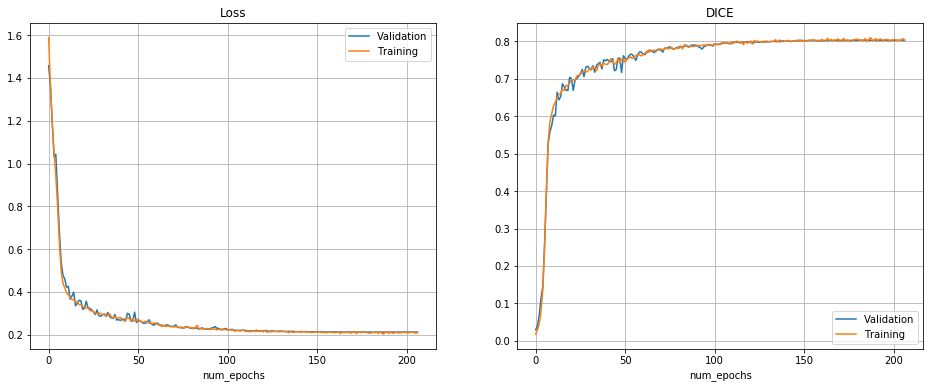

In [0]:
#plotting model losses and dice_coeff values
show_loss(loss_multiResUnet)

In [0]:
#best weights are dowloaded to PC
files.download('batch_multiresunet_weights.best.hdf5')

We get a 0.8033 dice_coef value after 210 epochs.


multiResUnet model gives the best solution with a  0.8033 dice_coeff value

Beyond this point, we are going to keep multiResUnet model. We will use best weigths to load the model and make preditions with images and check matches between predictions and original masks(ground truth)

For this checking we are going to select 10 images from validation set, make the predictions and plot the results.

In [0]:
#choosing first 10 images from validation set to test predictions
first_samples = img_val[0:10]
first_samples

,ImageId,EncodedPixels,ship,has_ship
1406,19bedd653.jpg,377002 1 377769 3 378536 5 379303 7 380071 8 3...,2,1
1593,b35d011b1.jpg,247097 3 247865 5 248633 5 249401 5 250169 5 2...,8,1
2116,25533d9fa.jpg,403453 2 404221 4 404988 7 405756 10 406523 13...,3,1
2933,2a3147179.jpg,NaN,0,0
4083,a8b38c84d.jpg,555071 1 555837 3 556604 5 557370 7 558137 7 5...,15,1
1834,1c2ad85ac.jpg,NaN,0,0
2144,d75145cf2.jpg,380874 2 381640 4 382406 7 383172 9 383938 12 ...,1,1
567,646d868da.jpg,458836 1 459603 4 460371 5 461138 8 461906 9 4...,7,1
707,a1b06a9be.jpg,427525 2 428290 5 429056 8 429821 11 430586 15...,3,1
1933,093962312.jpg,63346 2 64114 4 64881 7 65649 9 66416 12 67184...,5,1


In [0]:
def creating_arrays(df,new_size,name,model):
  #df: dataframe with contains images annotations
  #new size: size to reshape original image
  #model: neural network model used to make predictions
  img_path = os.path.join('airbus_ship_images_4414/',name)
  img = Image.open(img_path)
  img_resized = img.resize((new_size,new_size),Image.ANTIALIAS)
  #normalizing images to suit with network parameters    
  np_image = np.array(img_resized)/255
      
  mask_array=mask_gen(df,name)
      
  mask= Image.fromarray(mask_array)
  mask_resized = mask.resize((new_size,new_size),Image.ANTIALIAS)
      
  np_mask = np.array(mask_resized)
  #adding new dimension to suit with keras input parameters
  np_image_prediction=np_image[np.newaxis,:,:,:]
  
  np_prediction=model.predict(np_image_prediction)
  #after prediction shape dimensions are reduced to its original shape
  np_prediction_squeeze=np.squeeze(np_prediction,axis=(3,))
  #probability values are transformed in 0s and 1s
  np_prediction_squeeze=np.where(np_prediction_squeeze > 0.5, 1.,0.) 
  
  return np_image,np_mask,np_prediction_squeeze

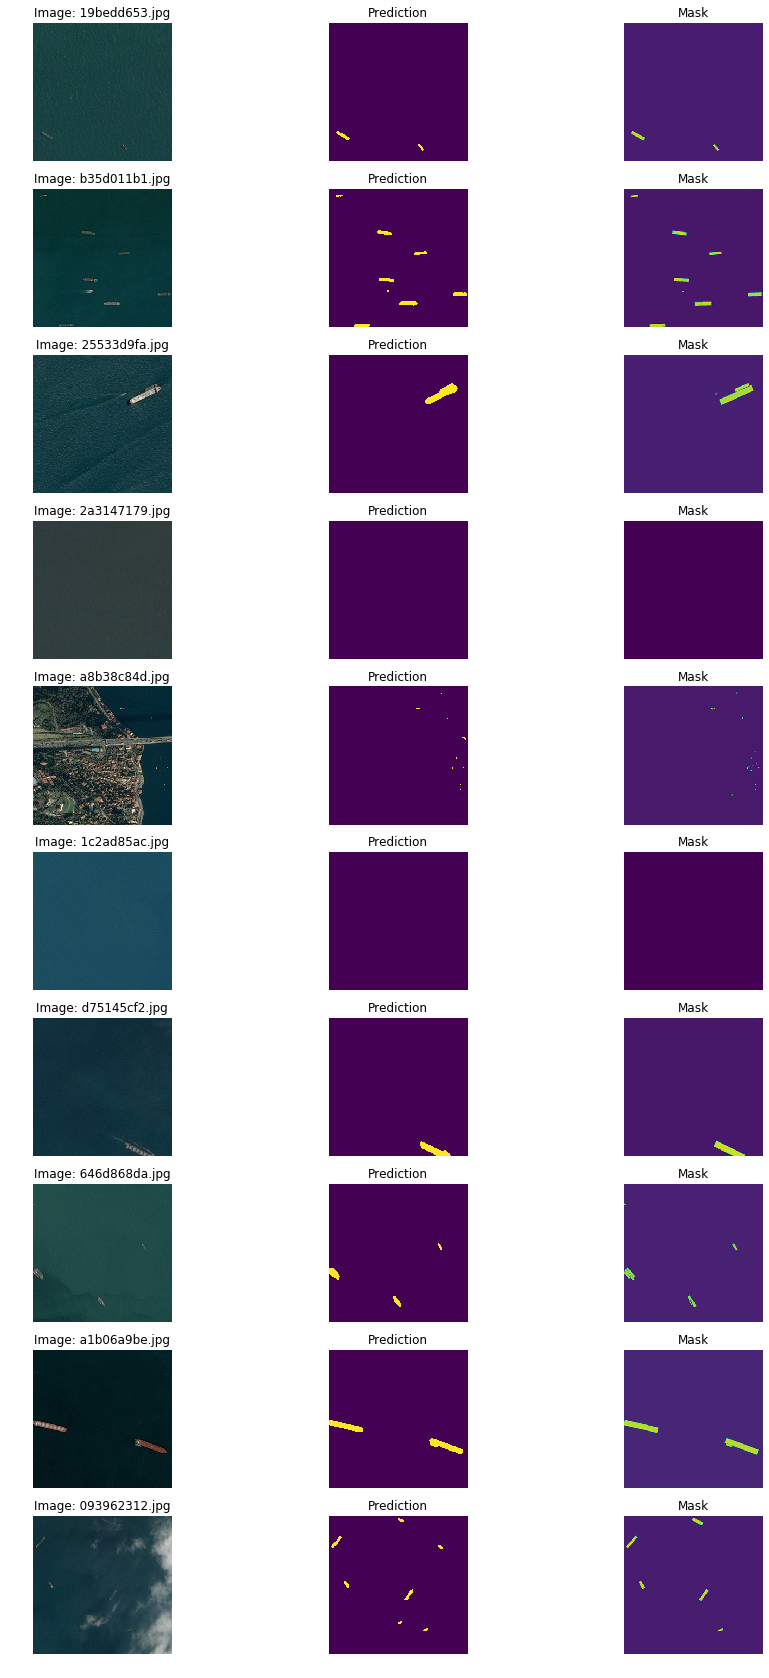

In [0]:
#plot for the first 10 samples of validation test: Image, Prediction and Original mask(Ground Truth)
fig, axarr = plt.subplots(first_samples.shape[0], 3, figsize = (15, first_samples.shape[0]*3))
[ax.axis('off') for ax in axarr.flatten()]
for (ax1, ax2, ax3),first_name in zip(axarr,first_samples['ImageId'].values):
  img_plt,mask_plt,pred_plt=creating_arrays(first_samples,256,first_name,multiResUnet)
  ax1.imshow(img_plt)
  ax1.set_title('Image: ' + first_name)
  ax2.imshow(pred_plt[0])
  ax2.set_title('Prediction')
  ax3.imshow(mask_plt)
  ax3.set_title('Mask')  

Once the predictions have been tested and plotted against original masks, we will upload a folder with testing images(200 samples) and generate a csv file with detected ships positions.

In [0]:
#uploading and unzipping of testing images
!rm -rf airbus_ship_images_test
!mkdir airbus_ship_images_test
downloaded = drive.CreateFile({'id':'1TrYlnGSNCQe8fSOrEpZ4Skn4Rt1CSA-1'})
downloaded.GetContentFile('test_images.rar')
!unrar e -y *.rar /content/airbus_ship_images_test/ -idq
!rm *.rar

In [0]:
#function copied from Kaggle plataform user
#Transforms mask in run length encoding
def rle_encode(img, min_max_threshold=1e-3):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
   
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [0]:
#function copied from Kaggle plataform user
#this function returns a list of run length encoding, each list value corresponds to a ship
def multi_rle_encode(img):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2)) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

In [0]:
#generation of dataframe with ships encoded using run-length encoding
def generate_dataframe(folder,original_size,new_size,model):
  
  df2 = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])

  row=0
  
  for filename in os.scandir(folder):
    #testing images reading
    img_path = folder+filename.name
    img = Image.open(img_path)
    #resizing of images to beapplied to model
    img_resized = img.resize((new_size,new_size),Image.ANTIALIAS)
    #image normalisation 
    np_image = np.array(img_resized)/255
    #shape modification to aply to keras model
    np_image_prediction=np_image[np.newaxis,:,:,:]
    #prediction
    np_prediction=model.predict(np_image_prediction)
    np_prediction_squeeze=np.squeeze(np_prediction,axis=(3,))
    #transform probabilities to 0s and 1s
    np_prediction_squeeze=np.where(np_prediction_squeeze > 0.5, 1.,0.)
    
    new_img = Image.fromarray(np_prediction_squeeze[0])
    #resizing mask to its original size
    new_img_resized=new_img.resize((original_size,original_size),Image.ANTIALIAS)
    np_new_image=np.array(new_img_resized)
    #ships position encoding
    result=multi_rle_encode(np_new_image)
    #generation of rows dataframe with features 'ImageId' and 'EncodedPixels'
    for str_encode in result:
    
      df2.loc[row]=[filename.name,str_encode]
      row +=1
    
  return df2

In [0]:
#generation of dataframe with features 'ImageId'(image file name) and EncodedPixels (ships position encoded with run length encoding)
dataframe_test= generate_dataframe('airbus_ship_images_test/',768,256,multiResUnet)
dataframe_test.head()

In [0]:
#generation of csv file
dataframe.to_csv('results_submission.csv', sep=',', encoding='utf-8')